In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ema_workbench import load_results
from unbreakable.analysis.analyzer import *
from unbreakable.analysis.visualizer import *
sns.set_theme(style="ticks")

## Load results and prepare outcomes

In [12]:
country = 'Nigeria'
figures_folder = f'../../reports/{country}/figures/'
tables_folder = f'../../reports/{country}/tables/'
return_period = 100
n_scenarios = 1000
n_policies = 0
income_loss = True

# Load the results and prepare the outcomes
results = load_results(f'../../results/{country}/return_period={return_period}, scenarios={n_scenarios}, policies={n_policies}, conflict=True.tar.gz')
outcomes = prepare_outcomes(results, add_uncertainties=False, add_policies=False)

## Consumption loss

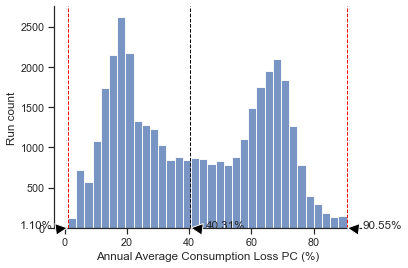

In [13]:
annotated_hist(outcomes, annotate=True)
plt.savefig(figures_folder + 'loss_distribution.png', dpi=300, bbox_inches='tight')

In [10]:
# Let's aggregate across scenarios and take the mean
# outcomes.iloc[:, 2:-1].groupby('region').mean(numeric_only=True).round(2).sort_values(by='annual_avg_consum_loss_pct', ascending=False)

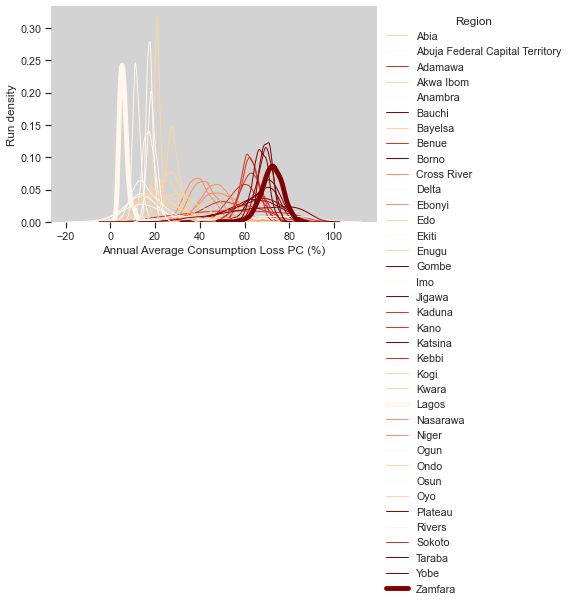

In [8]:
coloured_density_plots(outcomes, scheme='fisher_jenks', k=5, cmap='OrRd')
plt.savefig(figures_folder + 'consumption_loss_density.png', dpi=300, bbox_inches='tight')

## Number of new poor

In [9]:
tab = outcomes.iloc[:, 2:-1].groupby('region').describe().round(2)
column = 'n_new_poor'
tab = tab.sort_values(by=(column, 'mean'), ascending=False)
tab = tab[[column]].iloc[:,1:]
tab.index.name = 'Region'
tab.columns = ['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']
tab.style.format("{:,.0f}").background_gradient(cmap='Blues', axis=0)

,Mean,Std,Min,25%,50%,75%,Max
Region,,,,,,,
Kebbi,"49,900","5,811","33,226","45,710","49,950","53,990","69,020"
Bayelsa,"38,222","4,841","25,497","34,800","38,198","41,304","58,819"
Kogi,"34,910","5,653","19,416","30,879","34,721","38,762","52,595"
Yobe,"30,427","4,228","16,949","27,421","30,387","33,018","47,135"
Adamawa,"27,416","5,338","12,389","23,400","27,118","31,036","45,970"
Rivers,"26,228","7,334","6,428","21,296","26,140","30,866","52,202"
Benue,"25,407","4,599","12,246","22,303","25,109","28,727","46,731"
Imo,"25,278","6,737","8,654","20,367","24,888","29,676","51,957"
Jigawa,"19,156","4,673","6,057","16,030","19,118","22,217","34,719"


In [15]:
tab.index.name = 'region'
tab.to_excel(tables_folder + 'number_of_new_poor.xlsx')

## Raincloud 

In [11]:
regions = outcomes['region'].unique().tolist()
n_regions = len(regions)
colors = sns.color_palette('Set2', n_colors=len(regions))

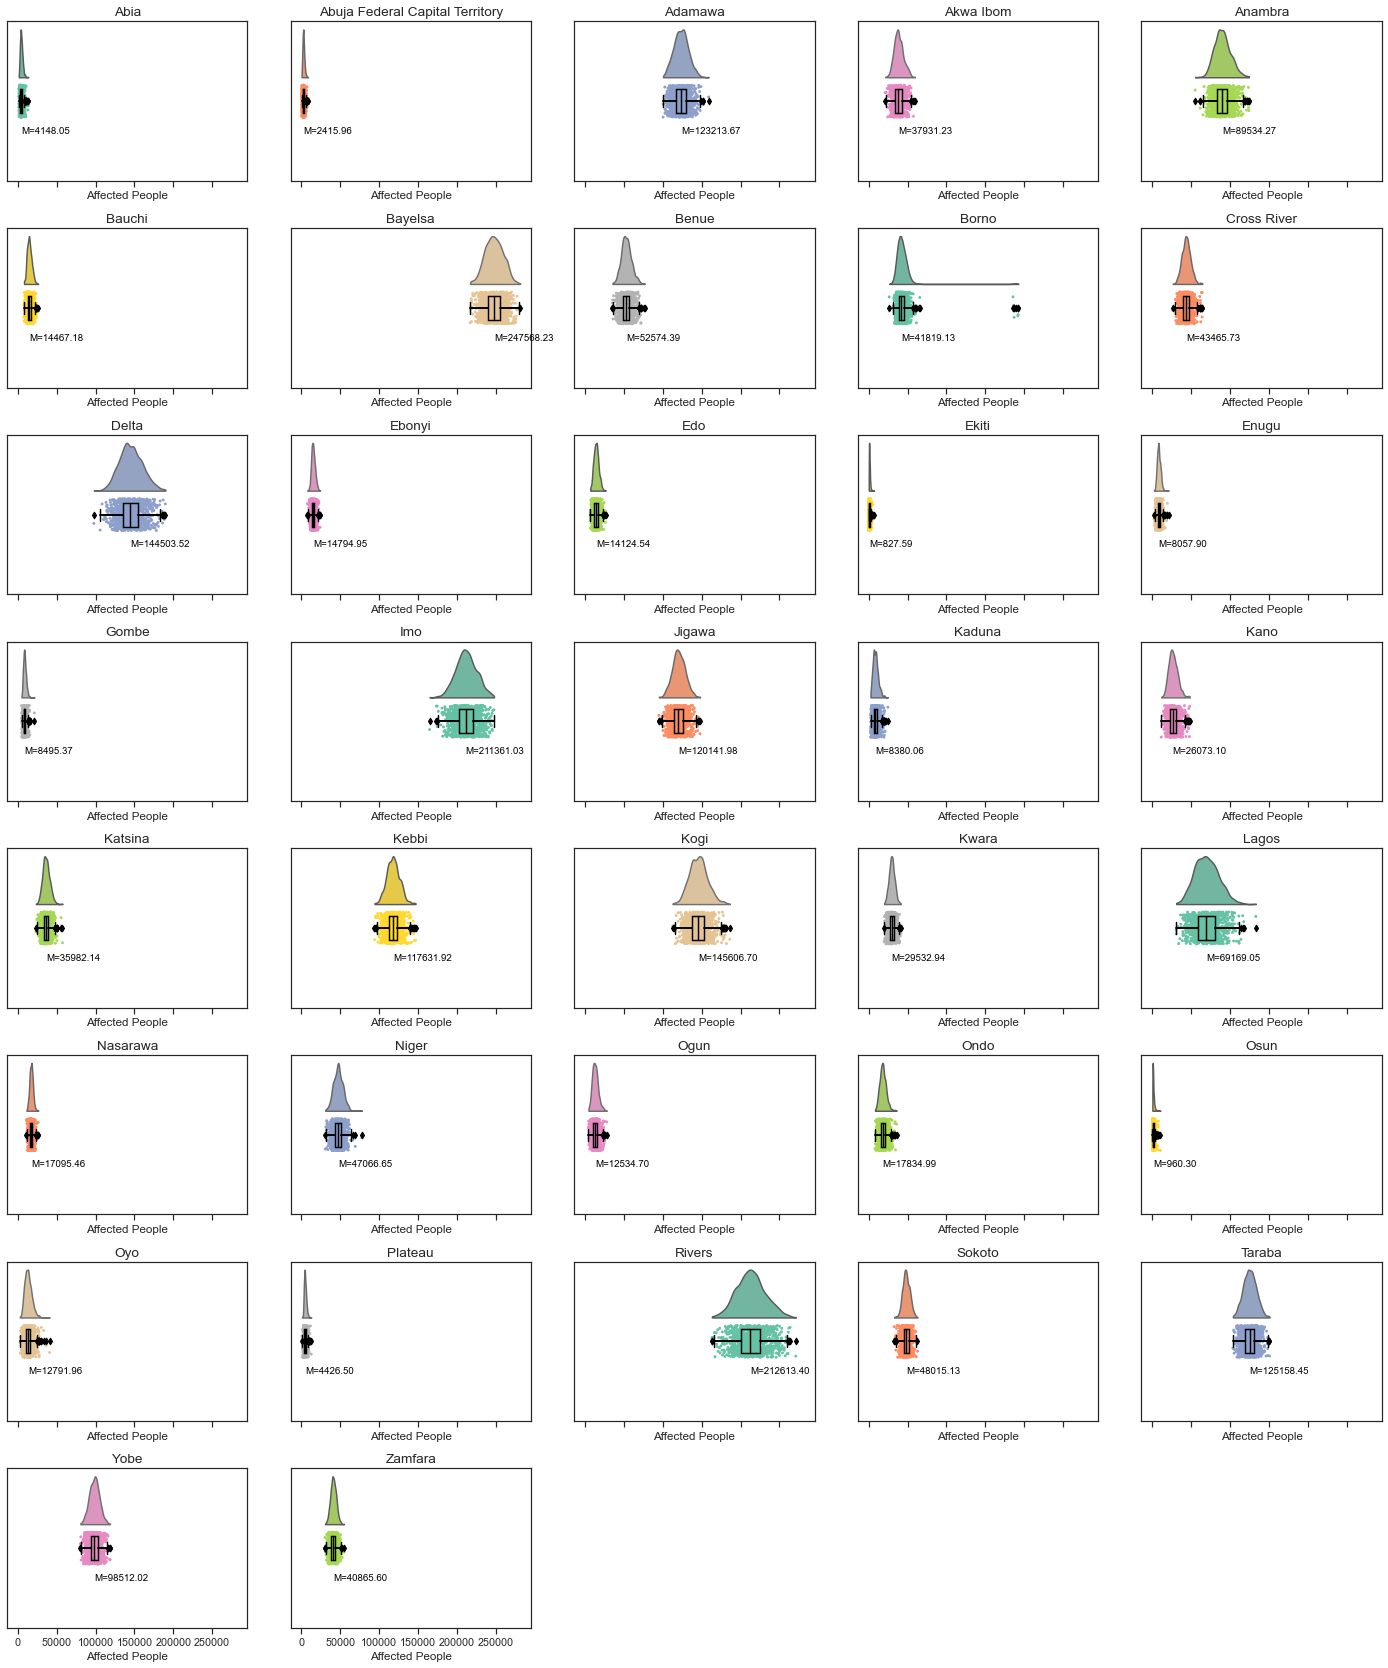

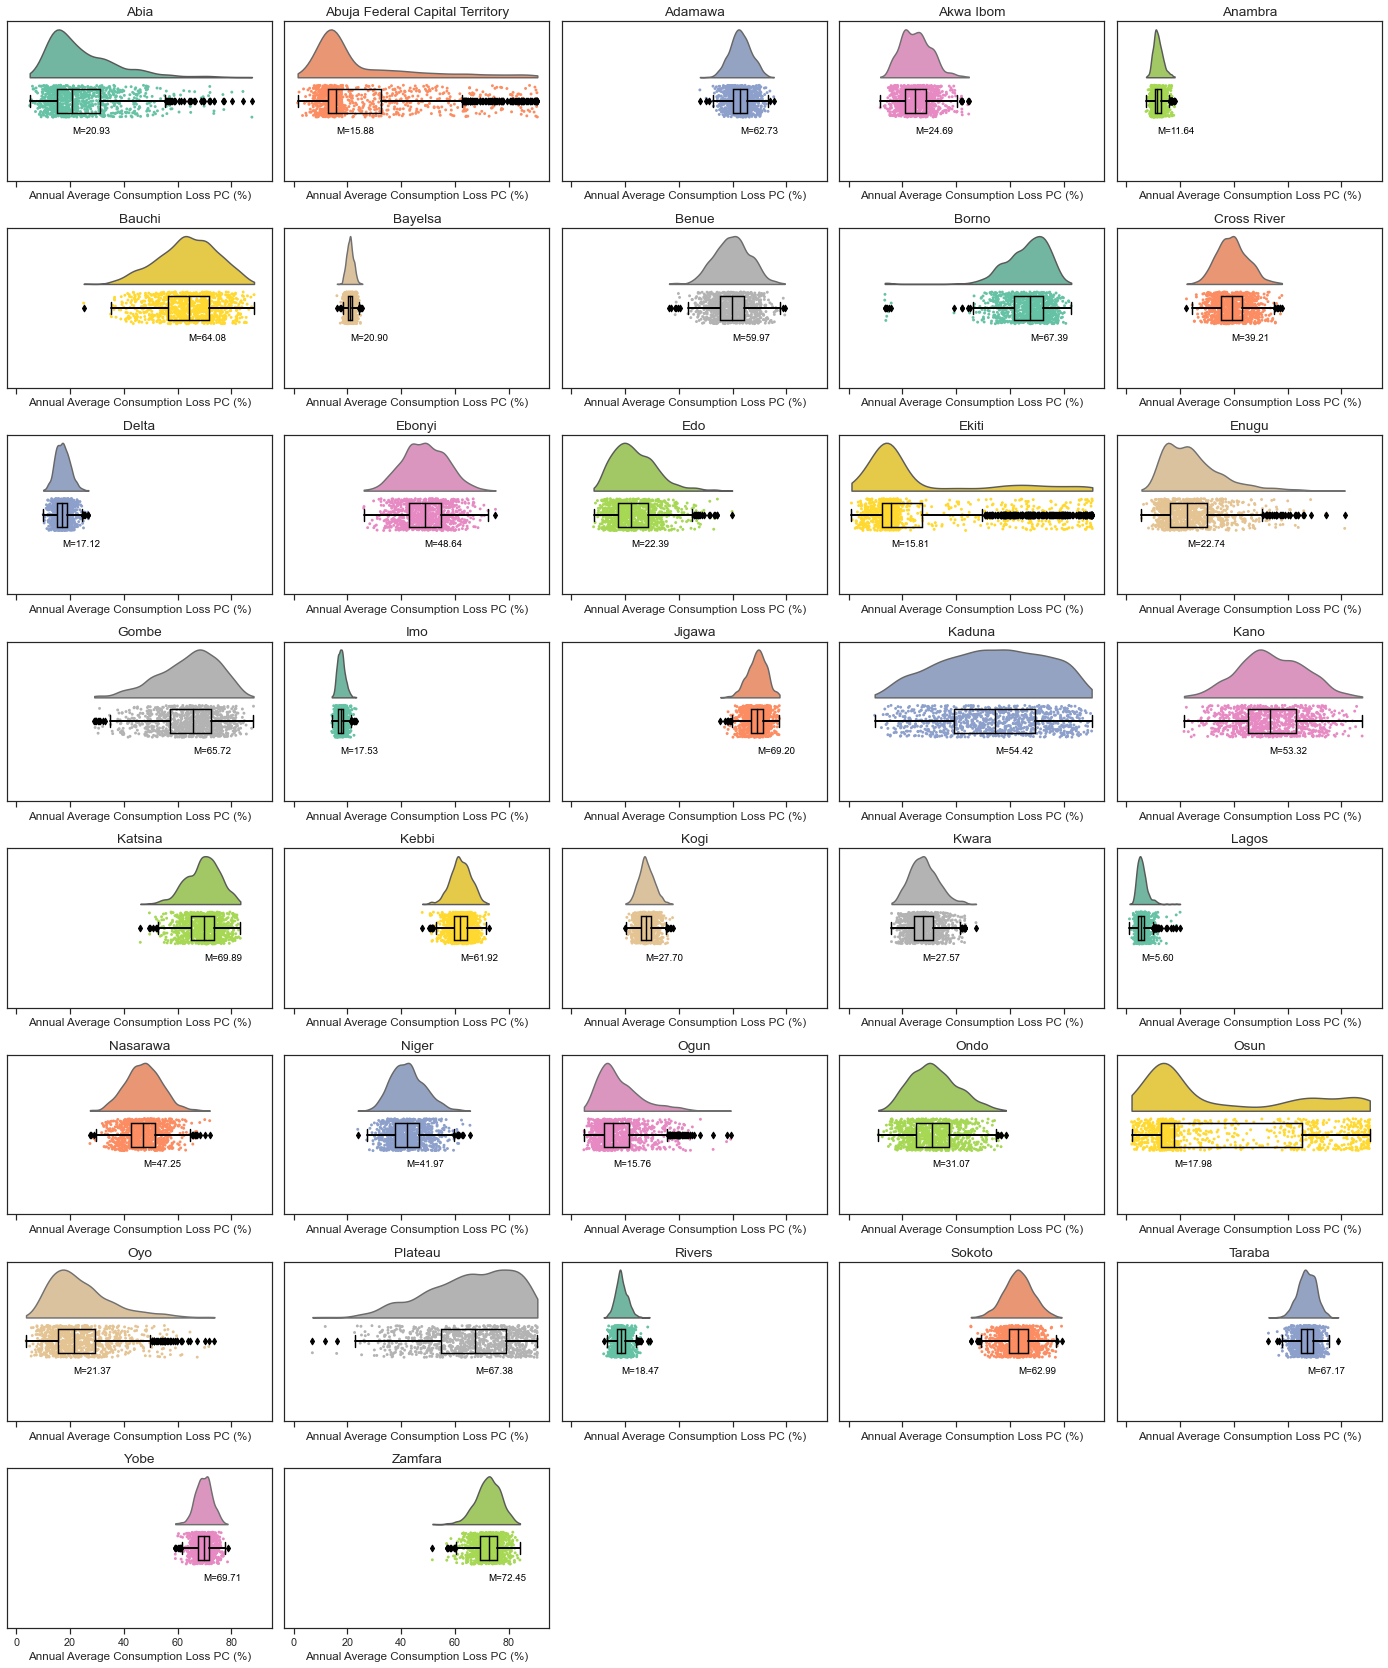

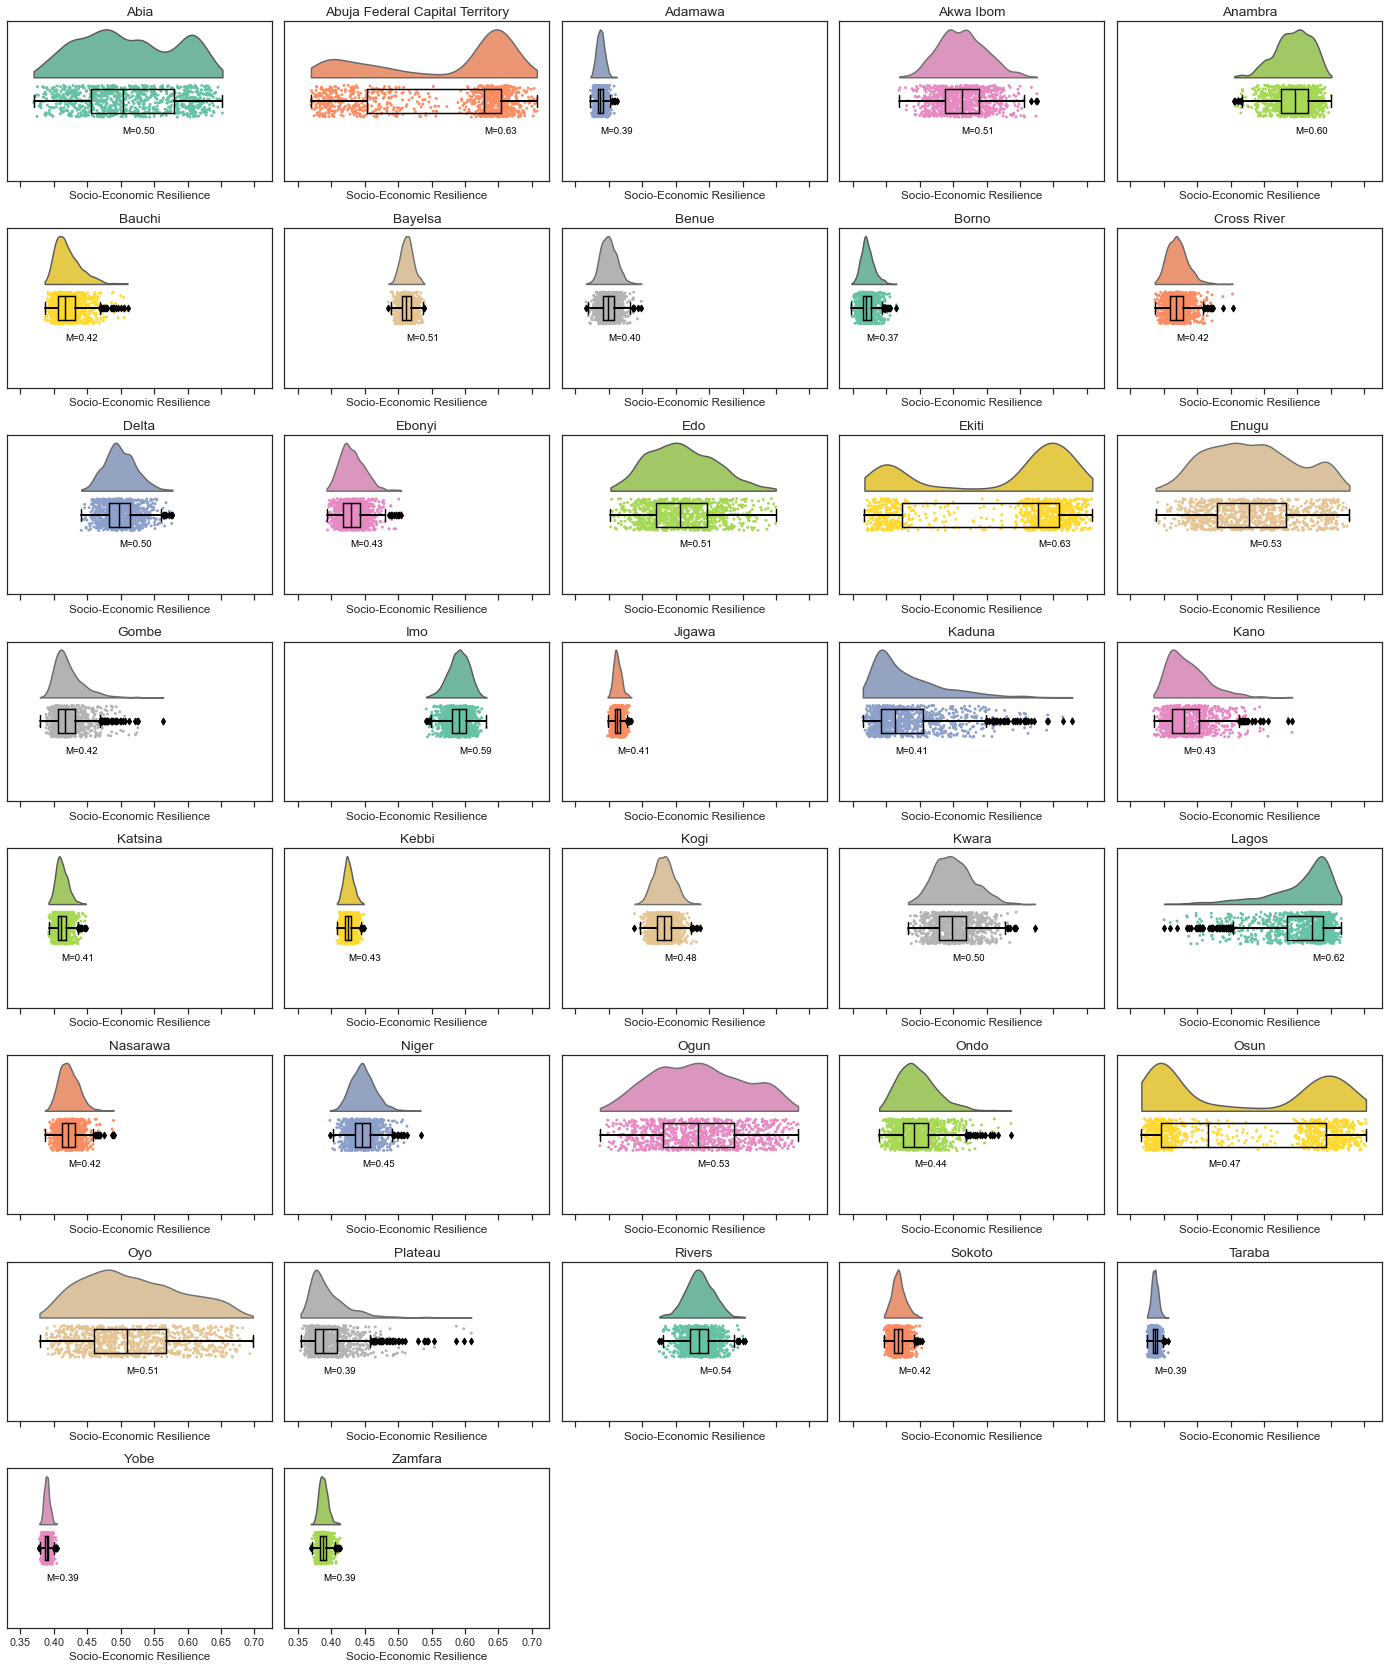

In [35]:
outcome_columns = [
    'n_aff_people',
    # 'n_new_poor_increase_pp',
    # 'n_new_poor',
    'annual_avg_consum_loss_pct',
    'r',
    # 'new_poverty_gap_initial',
    # 'new_poverty_gap_all',
]

outcome_names = [
    'Affected People',
    # 'New Poor Increase (p.p.)',
    # 'New Poor',
    f'Annual Average Consumption Loss PC (%)',
    'Socio-Economic Resilience',
    # 'New Poverty Gap Initial Poor',
    # 'New Poverty Gap All Poor'
    ]

for outcome_column, outcome_name in zip(outcome_columns, outcome_names):

    ncols = 5
    nrows = len(regions) // ncols + 1

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 3), sharex=True)

    # Flatten the axes
    ax = ax.flatten()
    for region in regions:
        # Select the region
        df = outcomes[outcomes['region'] == region].copy()

        # Make a half violin plot
        pt.half_violinplot(x=outcome_column,
                        y='policy',
                        data=df,
                        color=colors[regions.index(region)],
                        bw=.2,
                        cut=0.,
                        scale="area",
                        width=.6,
                        inner=None,
                        ax=ax[regions.index(region)])

        # Add stripplot
        sns.stripplot(x=outcome_column,
                    y='policy',
                    data=df,
                    color=colors[regions.index(region)],
                    edgecolor='white',
                    size=3,
                    jitter=1,
                    zorder=0,
                    orient='h',
                    ax=ax[regions.index(region)])

        # Add boxplot
        sns.boxplot(x=outcome_column,
                    y='policy',
                    data=df,
                    color="black",
                    width=.15,
                    zorder=10,
                    showcaps=True,
                    boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=True,
                    whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1,
                    orient='h',
                    ax=ax[regions.index(region)])

        ax[regions.index(region)].set_title(region, fontsize=14)
        ax[regions.index(region)].set_ylabel('')
        ax[regions.index(region)].set_xlabel(outcome_name)
        ax[regions.index(region)].set_yticklabels([])
        ax[regions.index(region)].set_yticks([])
        ax[regions.index(region)].text(df[outcome_column].median(), 0.2, f'M={df[outcome_column].median():.2f}', horizontalalignment='left', size='small', color='black')

    for i in range(len(regions), len(ax)):
        fig.delaxes(ax[i])

    fig.tight_layout()
    plt.savefig(f'../../reports/{country}/figures/{outcome_name}.png', dpi=300, bbox_inches='tight')

## Spatial outcomes

In [23]:
aggregation = 'median'
country = 'Nigeria'
aggregated_outcomes = get_spatial_outcomes(outcomes=outcomes, country=country, aggregation=aggregation)
aggregated_outcomes[['tot_exposed_asset', 'tot_consum_loss_npv', 'region_pml']] /= 1000000
aggregated_outcomes[['tot_exposed_asset', 'tot_consum_loss_npv', 'region_pml']] = aggregated_outcomes[['tot_exposed_asset', 'tot_consum_loss_npv', 'region_pml']].round(2)

In [24]:
columns_of_interest = ['shapeName', 'region_pml', 'annual_avg_consum_loss_pct', 'n_new_poor', 'r', 'geometry'] 
aggregated_outcomes = aggregated_outcomes[columns_of_interest]
aggregated_outcomes = aggregated_outcomes.rename(columns={'shapeName': 'region', 'region_pml': 'PML (M$)', 'annual_avg_consum_loss_pct': 'Annual Average Consumption Loss PC (%)', 'n_new_poor': 'Number of New Poor', 'r': 'Socio-Economic Resilience'})
aggregated_outcomes.to_file('../../reports/Nigeria/tables/median_outcomes.json', driver='GeoJSON')

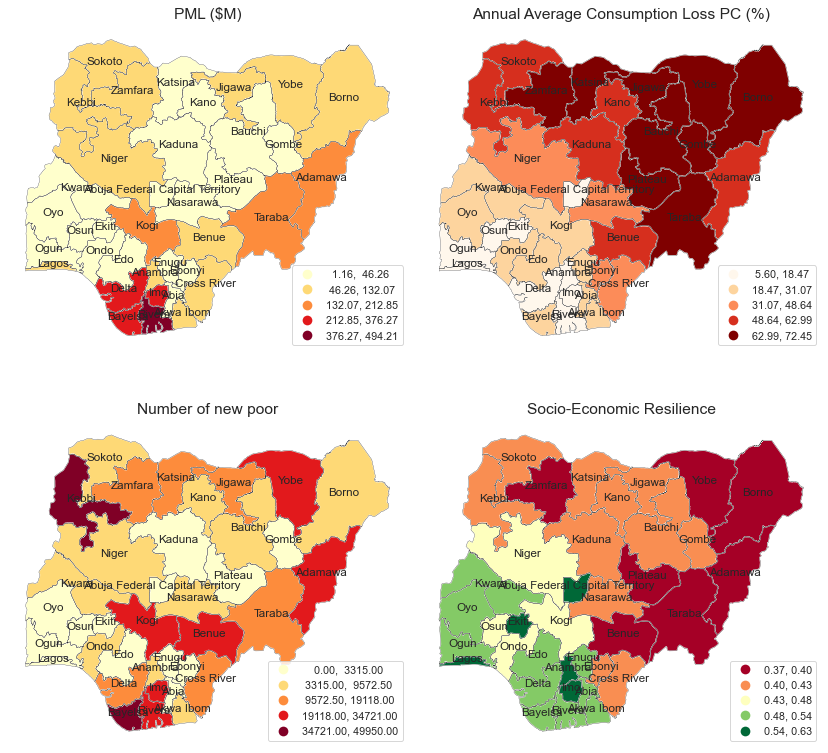

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
k = 5
columns = ['region_pml', 'annual_avg_consum_loss_pct', 'n_new_poor', 'r']
titles = ['PML ($M)', 'Annual Average Consumption Loss PC (%)', 'Number of new poor', 'Socio-Economic Resilience']
cmaps = ['YlOrRd', 'OrRd', 'YlOrRd', 'RdYlGn']

scheme = 'fisher_jenks'
# flatten the axes
ax = ax.flatten()
for i, column in enumerate(columns):
    title = titles[i]
    cmap = cmaps[i]
    aggregated_outcomes.plot(column=column, scheme=scheme, k=k, cmap=cmap, legend=True, ax=ax[i], legend_kwds={
        # "title":title, 
        "loc" : "lower right"})
    aggregated_outcomes.plot(ax=ax[i], color='none', edgecolor='black', linewidth=0.25)
    ax[i].axis('off')
    ax[i].set_title(title, fontsize=16)
    for idx, row in aggregated_outcomes.iterrows():
        ax[i].annotate(text=row['shapeName'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=12)
plt.tight_layout()
plt.savefig(figures_folder + f'soc_econ_res_map.png', dpi=300, bbox_inches='tight')

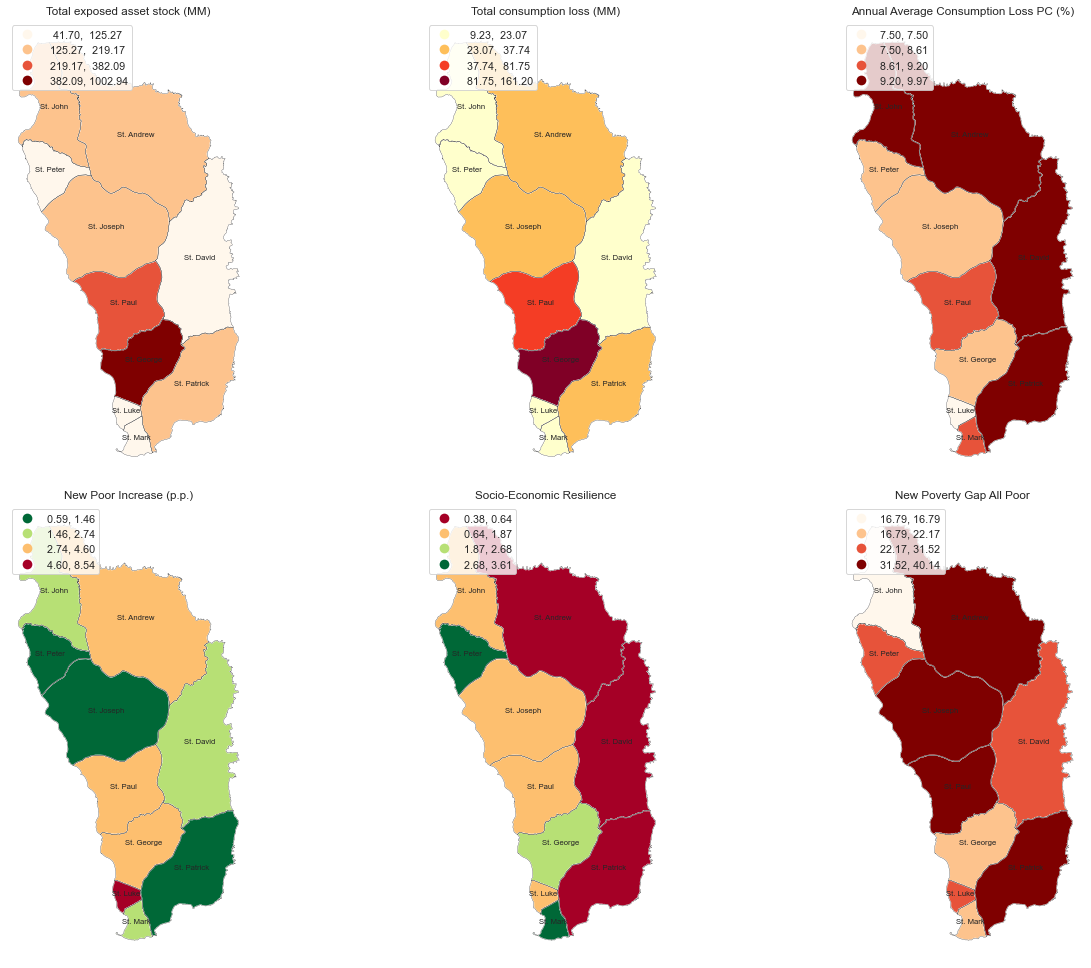

In [43]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 14))

outcomes_to_plot = [
    'tot_exposed_asset',
    'total_consumption_loss',
    'annual_average_consumption_loss_pct',
    'n_new_poor_increase_pp',
    'r',
    'new_poverty_gap_all']

titles = ['Total exposed asset stock (MM)',
          'Total consumption loss (MM)',
          # 'Wt. Ann. Avg. Consump. Loss p.c. (%)',
          'Annual Average Consumption Loss PC (%)',
          'New Poor Increase (p.p.)',
          'Socio-Economic Resilience',
          'New Poverty Gap All Poor']

cmaps = ['OrRd', 'YlOrRd', 'OrRd', 'RdYlGn_r', 'RdYlGn', 'OrRd']

k = 4
for i, outcome in enumerate(outcomes_to_plot):
    aggregated_outcomes.plot(column=outcome, scheme='fisher_jenks', cmap=cmaps[i], k=k, ax=ax[i//3, i % 3], legend=True, legend_kwds={"loc": "upper left"})
    aggregated_outcomes.plot(ax=ax[i//3, i % 3], color='none', edgecolor='black', linewidth=0.25)
    ax[i//3, i % 3].set_title(titles[i])
    ax[i//3, i % 3].axis('off')
    for idx, row in aggregated_outcomes.iterrows():
        ax[i//3, i % 3].annotate(text=row['NAME'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)

# fig.suptitle(f'{aggregation.capitalize()} of 3,000 replications', fontsize=16)

fig.tight_layout()
if savefig:
    plt.savefig(figures_folder +
        f'{aggregation}_outcomes_spatially.png', dpi=300, bbox_inches='tight')

A bivariate or bi-variate choropleth helps to visualise relations between two variables spatially. 

In [118]:
# Load asset damage data
# asset_damage = pd.read_excel('../data/processed/asset_damage/Saint Lucia.xlsx')
# asset_damage['district'].replace({'AnseLaRayeCanaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
# gdf = pd.merge(aggregated_outcomes, asset_damage, left_on='NAME_1', right_on='district', how='left')

In [92]:
# x_name = 'r'
# y_name = 'pml'
# x_label = 'Soc.-econ. res.'
# y_label = 'PML'

# tab = bivariate_choropleth(gdf.copy(), x_name, y_name, x_label, y_label, scheme='fisher_jenks', figsize=(7,6), return_table=True)
# if savefig:
#     plt.savefig('../reports/figures/analysis/bivariate_choropleth.png', dpi=300, bbox_inches='tight')

In [93]:
# nine_quadrants_plot(gdf.copy(), x_name, y_name)
# plt.xlabel('Socio-Economic Resilience')
# plt.ylabel('PML')
# if savefig:
#     plt.savefig('../reports/figures/analysis/9_quadrants.png', dpi=300, bbox_inches='tight')